<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/HW_0919_StackedRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stacked Regressions to predict House Prices

## Intro

In [1]:
#import necessary libraries

import numpy as np #linear algebra
import pandas as pd #data processing, CSV file (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format',lambda x: '{:.3f}'.format(x)) #limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

In [2]:
#import datasets

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

train = pd.read_csv('/content/gdrive/MyDrive/stackrg_train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/stackrg_test.csv')

Mounted at /content/gdrive


In [3]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
#check the numbers of samples and features
print("The train data size before dropping ID feature is : {}".format(train.shape))
print("The test data size before dropping ID feature is : {}".format(test.shape))

#save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#drop the 'Id' column since it's unnecessary for the prediction process
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

#check again the data size after dropping the 'Id' variable
print('\nThe train data size after dropping Id feature is : {}'.format(train.shape))
print('\nThe test data size after dropping Id feature is : {}'.format(test.shape))

The train data size before dropping ID feature is : (1460, 81)
The test data size before dropping ID feature is : (1459, 80)

The train data size after dropping Id feature is : (1460, 80)

The test data size after dropping Id feature is : (1459, 79)


## Data Processing

### Outliers

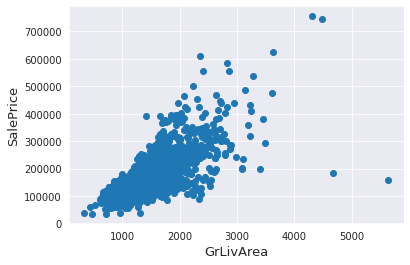

In [6]:
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()

오른쪽 아래에서 매우 큰 GrLivArea를 갖고 있으며 SalePrice가 매우 낮은 2개의 데이터가 보인다. 이것들은 매우 큰 outlier들이므로, 제거해야 한다.

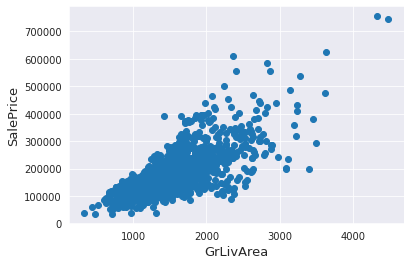

In [7]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'],train['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()

### Target Variable

**SalePrice** is the variable we need to predict.


 mu = 180932.92 and sigma = 79467.79



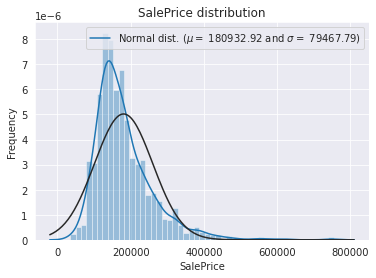

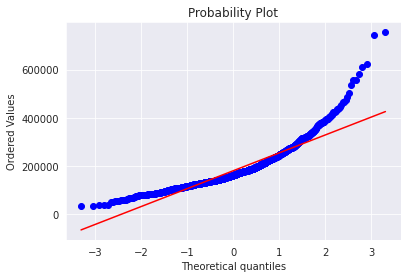

In [8]:
sns.distplot(train['SalePrice'],fit=norm)

#Get the fitted parameters used by the function.
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))

#Now plot the distribution.
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot=plt)
plt.show()

Log-transformation of the target variable


 mu = 2.57 and sigma = 0.03



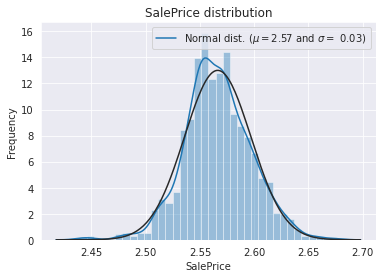

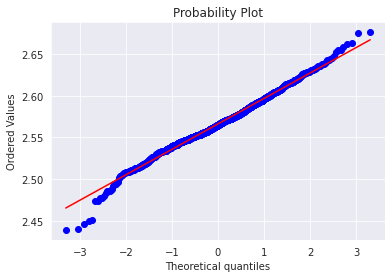

In [10]:
#We use the numpy function log1p which applies log(1+x) to all elements of the column
train['SalePrice']=np.log1p(train['SalePrice'])

#Check the new distribution
sns.distplot(train['SalePrice'],fit=norm)

#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))

#plot the distribution
plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQplot
fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot=plt)
plt.show()

The skew seems corrected now, and the data appears more normally distributed.

### Features Engineering

In [14]:
#concatenate the train&test data in the same dataframe
ntrain = train.shape[0] #dataname.shape[0] : 행 개수 반환, dataname.shape[1] : 열 개수 반환
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace=True)
print('all_data size is : {}'.format(all_data.shape))

all_data size is : (2917, 79)


#### Missing Data

In [17]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100 #isnull().sum() : 칼럼별 결측값 개수 구해서 Series 형태로 출력
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

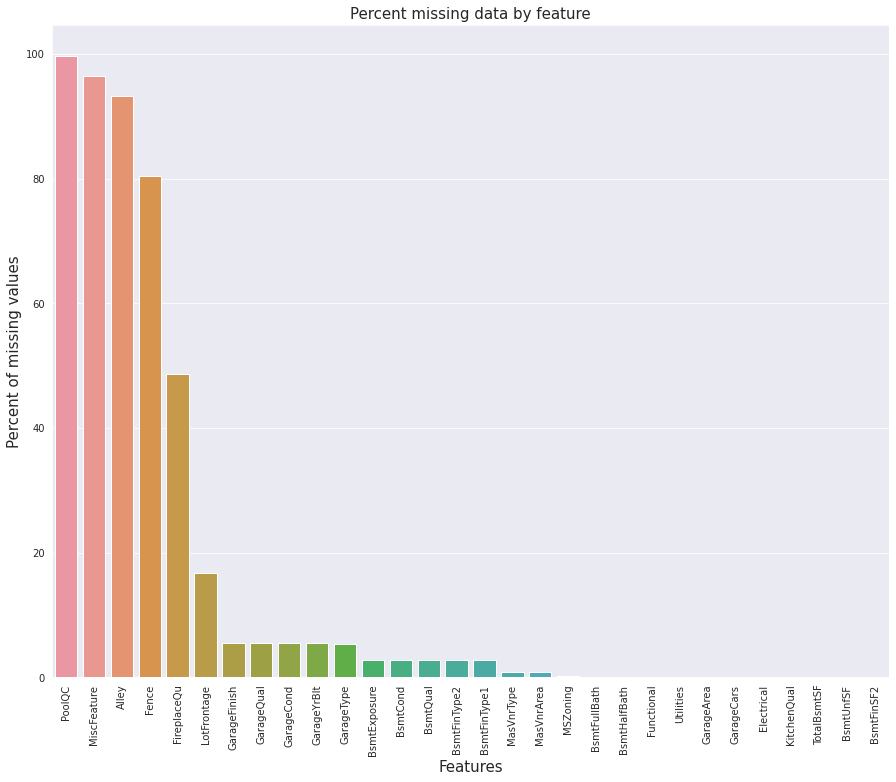

In [18]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index,y=all_data_na)
plt.xlabel('Features',fontsize=15)
plt.ylabel('Percent of missing values',fontsize=15)
plt.title('Percent missing data by feature',fontsize=15)

#### Data Correlation

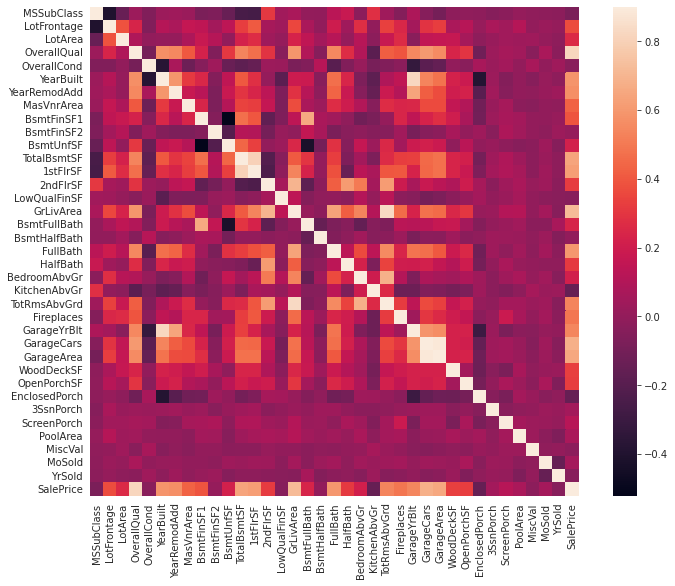

In [19]:
#correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.9,square=True)

#### Imputing missing values

* PoolQC : 데이터 설명에 따르면 NA는 'No Pool'을 의미한다. 이에 따라 99%의 결측치 비율이 설명된다.(대부분의 집에는 수영장이 없기 때문)

In [21]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

* MiscFeature : 데이터 설명에 따르면 NA는 'no misc feature'를 의미한다.

In [22]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

* Alley : 데이터 설명에 따르면 NA는 'no alley access'를 의미한다.

In [24]:
all_data['Alley'] = all_data['Alley'].fillna('None')

* Fence : 데이터 설명에 따르면 NA는 'no fence'를 의미한다.

In [25]:
all_data['Fence'] = all_data['Fence'].fillna('None')

* FireplaceQu : 데이터 설명에 따르면 NA는 'no fireplace'를 의미한다.

In [26]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

* LotFrontage : area of the each street connected to the house property는 neighborhood의 다른 집들과 비슷한 영역을 갖고 있을 것으로 예상되므로, 결측치를 median 값으로 채울 수 있다.

In [32]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data['LotFrontage']=all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

코드 참고 링크 : https://seong6496.tistory.com/244

* GarageType, GarageFinish, GarageQual and GarageCond : 결측치를 None으로 대체

In [34]:
for col in ('GarageType','GarageFinish','GarageQual','GarageCond'):
  all_data[col] = all_data[col].fillna('None')

* GarageYrBlt, GarageArea, GarageCars : 결측치를 0으로 대체(Garage가 없으면 당연히 Garage안에 Car도 없으므로)

In [35]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
  all_data[col] = all_data[col].fillna(0)

* BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath : 결측치를 0으로 대체(지하실이 없는 경우 결측값이 0일 수 있다.)

In [36]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

* BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 : 지하실과 관련된 categorical 변수들. 결측값은 지하실이 없는 경우이다.

In [58]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
  all_data[col] = all_data[col].fillna('None')

* MasVnrArea, MasVnrType : Area의 결측치는 0, Venner는 None으로 대체

In [38]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

* MSZoning : 최빈값 'RL'로 결측치를 대체

In [43]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

* Utilities : 이 categorical 변수는 1개의 NoSeWa와 2개의 NA를 제외하면 모두 AllPub이다. 'NoSeWa'가 training set에 있기 때문에, 이 피처는 예측모델에 좋은 영향을 끼치지 못할 것이다. 따라서 이 행을 drop해야 한다.

In [45]:
all_data = all_data.drop(['Utilities'], axis=1)

* Functional : 데이터 설명에 따르면 NA는 'typical'을 의미한다.

In [46]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

* Electrical : 하나의 NA값을 갖고 있으므로 최빈값으로 대체한다.

In [47]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

* KitchenQual : Electrical과 마찬가지로 한다.

In [48]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

* Exterior1st and Exterior2nd : Electrical과 마찬가지로 한다.

In [49]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

* SaleType : Electrical과 마찬가지로 한다.

In [50]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

* MSSubClass : NA는 No building class를 의미할 것이므로 None으로 대체

In [51]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [52]:
#Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


There remains no missing value.

#### More Features Engineering

[Transforming some numerical variables that are really categorical]

In [56]:
#MSSubClass=The building class
all_data['MSSubClass']=all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

[Label Encoding some categorical variables that may contain information in their ordering set]

In [60]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

#process columns, apply LabelEncoder to categorical features
for c in cols:
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values)) #LabelEncoder를 fit : LabelEncoder() 출력
  all_data[c] = lbl.transform(list(all_data[c].values)) #실제 Encoding 수행

#shape
print('Shape all_data : {}'.format(all_data.shape))

Shape all_data : (2917, 78)


[Adding one more important feature]

Area와 관련된 feature들은 house price를 결정하는 데 매우 중요하기 때문에, 우리는 각 집의 지하실, 1층, 2층의 total area를 의미하는 하나의 피처를 add하기로 했다.

In [61]:
# Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

[Skewed Features]

In [63]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

#Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False) #dropna()로 1개라도 결측값이 있는 행은 제거하고 skew(왜도) 계산
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


[Box Cox Transformation of (highly) skewed features]

We use the scipy function boxcox1p which computes the Box-Cox transformation of $1+x$

Setting $\lambda=0$ is equivalent to log1p used above for the target variable.

In [64]:
skewness = skewness[abs(skewness)>0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
  #all_data[feat]+=1
  all_data[feat]=boxcox1p(all_data[feat],lam)

#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


[Getting dummy categorical features]


In [65]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [66]:
#Getting the new train and test sets. 반반 나눈다.
train=all_data[:ntrain]
test=all_data[ntrain:]

### Modelling

In [67]:
#import libraries
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

[Define a cross validation strategy] (이해안됨)

In [68]:
#Validation function
n_folds = 5

def rmsle_cv(model):
  kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(train.values) #in order to shuffle the dataset prior to cross-validation
  rmse = np.sqrt(-cross_val_score(model,train.values,y_train,scoring='neg_mean_squared_error',cv=kf))
  return(rmse)

#### Base Models

* Lasso Regression : very sensitive to outliers. By using Robustscaler(), we made it more robust on them.

In [69]:
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=1))

* ElasticNet Regression : again made robust to outliers

In [70]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

* Kernel Ridge Regression

In [71]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

* Gradient Boosting Regression : With huber loss that makes it robust to outliers

In [72]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

* XGBoost

In [73]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

* LightGBM

In [74]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

[Base models scores]

In [75]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0098 (0.0006)



In [76]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.0097 (0.0006)



In [77]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.0098 (0.0007)



In [78]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.0091 (0.0007)



In [79]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.0188 (0.0011)



In [80]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.0091 (0.0005)



### Stacking models

#### Simplest Stacking approach : Averaging base models

[Averaged base models class]

In [81]:
class AveragingModels(BaseEstimator,RegressorMixin,TransformerMixin):
  def __init__(self,models):
    self.models = models

  #define clones of the original models to fit the data in
  def fit(self,X,y):
    self.models_ = [clone(x) for x in self.models]

    #train cloned base models
    for model in self.models_:
      model.fit(X,y)
    
    return self

  #do the predictions for cloned models and average them
  def predict(self,X):
    predictions = np.column_stack([model.predict(X) for model in self.models_])
    return np.mean(predictions,axis=1)

[Average Base Models Score]

In [82]:
averaged_models = AveragingModels(models=(ENet,GBoost,KRR,lasso))
score = rmsle_cv(averaged_models)
print("Averaged base models score : {:.4f} ({:.4f})\n".format(score.mean(),score.std()))

Averaged base models score : 0.0088 (0.0006)



간단한 stacking approach로 점수가 향상되었다.

#### Less simple stacking : Adding a Meta-model

We add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

과정은 다음과 같다.

1. Split the total training set into two disjoint sets (here train and .holdout )

2. Train several base models on the first part (train)

3. Test these base models on the second part (holdout)

4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

[Stacking averaged models class]

In [83]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    #again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        #Train cloned base models then create out-of-fold predictions that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        #Train the cloned meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

[Stacking averaged models score]

To make the two approaches comparable (by using the same number of models) , we just average Enet KRR and Gboost, then we add lasso as meta-model.

In [84]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.0087 (0.0005)


meta learner를 더하여 더 좋은 점수를 얻었다.

### Ensembling StackedRegressor, XGBoost and LightGBM

We add XGBoost and LightGBM to the StackedRegressor defined previously.

In [85]:
def rmsle(y,y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

#### Final Training and Prediction

[StackedRegressor]

In [86]:
stacked_averaged_models.fit(train.values,y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train,stacked_train_pred))

0.005804760334217806


[XGBoost]

In [87]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.017329901066238527


[LightGBM]

In [88]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.005670419696568919


In [89]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.006626956103436006


[Ensemble prediction]

In [90]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

[Submission]

In [91]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)